In [300]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()
from scipy import stats

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Strategy Outline
1. Short (lower strike) puts and (higher strike) calls
2. Strategy assumes vol will stay muted and we harvest theta yield over time
3. Find risk-neutral implied probabiltiies of option expiring in the money for the puts and calls
4. Short calls where the probability of the option expiring with price > chosen strike is less than 10% -15%
5. Short puts where the probability of the option expiring with price < chosen strike is less than 10%-15%
6. Stop-loss when floating loss on spread is 2 times more than premium to be earned at expiry
6. In essence, probability of stopping out per trade will be 20%-30% at initiation since could be 60% at the highest (at which point we will stop out)

In [230]:
hdata = HistData('ETH')

## Options

In [231]:

opt = Options('ETH')
curr_price = hdata.get_idx_price()
#curr_price

## Get all active Eth options

### Get actively traded option chains

In [232]:
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call')
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put')
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

748 active options.
1710589911128
Expiration Date:  2024-03-29 16:00:00
748 active options.
1710589926784
Expiration Date:  2024-03-29 16:00:00


### Get Implied Probabilities
1. First method is to use the IV's themselves as the vol to calculate the implied probabilities
2. Second method is to use the atm strike's IV to calcualte the implied probabilities (Assumes a true normal distribution)

## Method 1

In [233]:
mu = 0.5
t = (option_chain_call['expiration_date'].iloc[0]-pd.datetime.today()).days/360
curr_price = curr_price * np.exp(mu*t)
curr_price

3169.437141905523

In [234]:
option_chain_call_adj=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put_adj=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put_adj,option_chain_call_adj])

1.6353938364820366


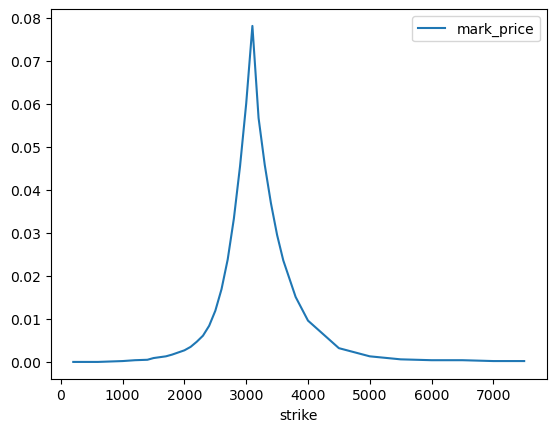

In [235]:
option_chain_full[['strike','mark_price']].set_index('strike').plot()
skewness = stats.skew(option_chain_full[['strike','mark_price']].set_index('strike'))[0]
print(skewness)

<Axes: xlabel='strike'>

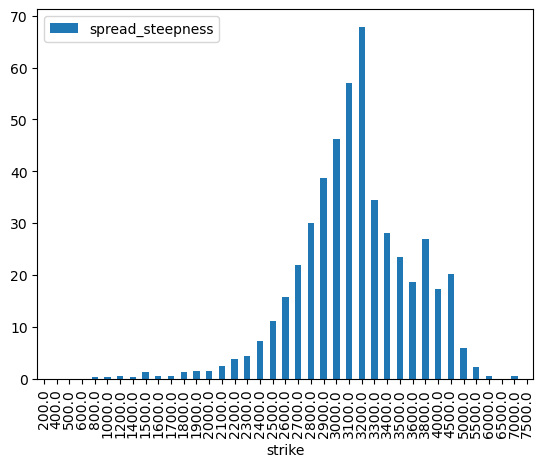

In [254]:
px_steepness=abs(option_chain_full[['mark_price']].diff()*curr_price)
px_steepness.columns = ['spread_steepness']
px_steepness.index = option_chain_full['strike']
px_steepness.plot(kind='bar')
#We can use the put/call spread steepness to identify which legs command the highest premium to short

In [236]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_call['scaled_iv']/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_put['scaled_iv']/100)


option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])
option_chain_full['implied_probability'] = option_chain_full['implied_probability']*(0.5/option_chain_full['implied_probability'].max())

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

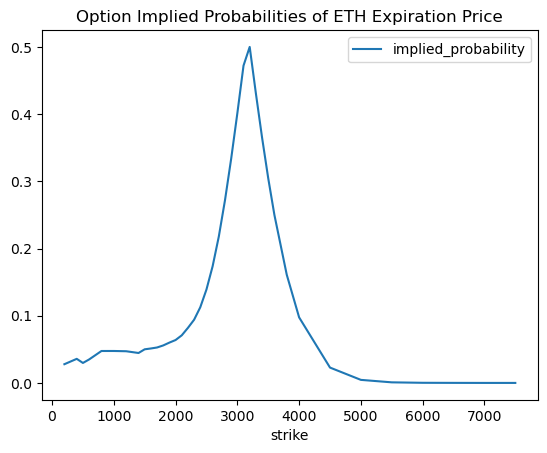

In [237]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [238]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,200.0,0.027859
0,400.0,0.035827
0,500.0,0.029719
0,600.0,0.034907
0,800.0,0.047510
0,1000.0,0.047529
0,1200.0,0.047150
0,1400.0,0.044544
0,1500.0,0.050022
0,1600.0,0.051258


## Method 2

In [203]:
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call')
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put')
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

746 active options.
1710555152586
Expiration Date:  2024-03-29 16:00:00
746 active options.
1710555167657
Expiration Date:  2024-03-29 16:00:00


In [204]:
call_iv = option_chain_call[option_chain_call['strike']==curr_price- curr_price%100]['scaled_iv'][0]
put_iv = option_chain_put[option_chain_put['strike']==curr_price- curr_price%100]['scaled_iv'][0]

In [205]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*call_iv/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*put_iv/100)

In [206]:
option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

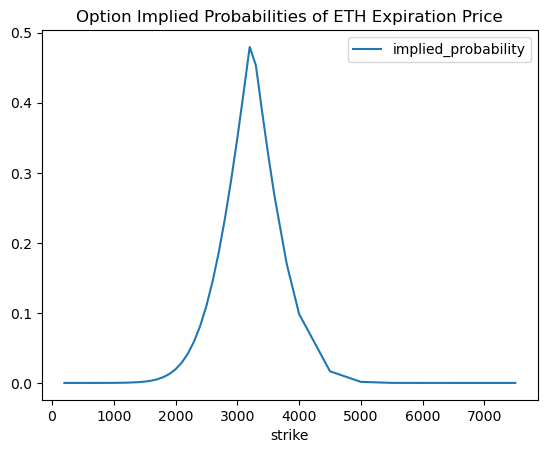

In [207]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [208]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,200.0,1.860830e-07
0,400.0,1.031203e-06
0,500.0,2.330647e-06
0,600.0,5.126867e-06
0,800.0,2.287962e-05
0,1000.0,9.170502e-05
0,1200.0,3.303650e-04
0,1400.0,1.070590e-03
0,1500.0,1.852831e-03
0,1600.0,3.124149e-03


## Vol Skew

<Axes: xlabel='strike'>

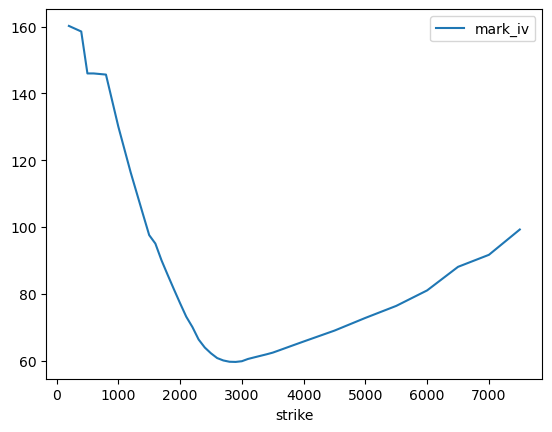

In [209]:
option_chain_full[['strike','mark_iv']].set_index('strike').plot()

## IV Adjusted Premium Calc

In [210]:
option_chain_full['adjusted_iv']=(option_chain_full['mark_iv'])**3
option_chain_full['iv_adjusted_mark_price']=option_chain_full['adjusted_iv']*option_chain_full['mark_price']

<Axes: xlabel='strike'>

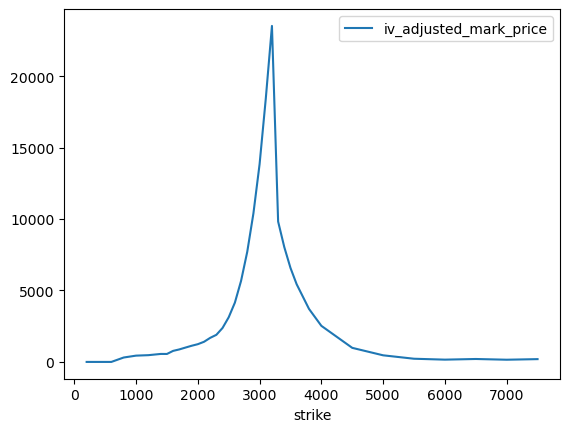

In [211]:
option_chain_full[['strike','iv_adjusted_mark_price']].set_index('strike').plot()

In [212]:
iv_gradient = pd.DataFrame(abs(option_chain_full['mark_iv'].diff()))
iv_gradient.index = option_chain_full['strike']
iv_gradient = iv_gradient[(iv_gradient.index>curr_price - 1000) & (iv_gradient.index<curr_price +1000)]

<Axes: xlabel='strike'>

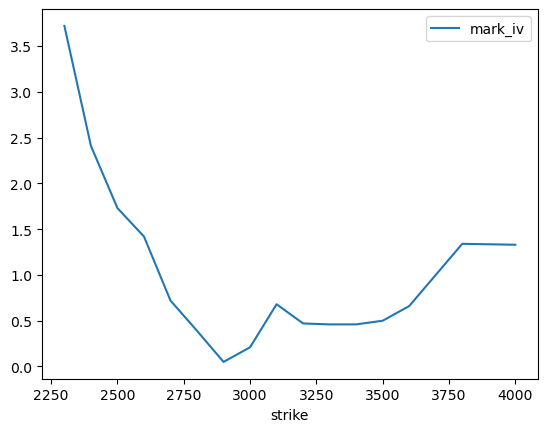

In [213]:
iv_gradient.plot()

In [293]:
start = int(pd.to_datetime('20221231').timestamp()*1000)
end = int(pd.datetime.today().timestamp()*1000)
timeframe = '1D'

# Offline

In [3]:
import os
import pandas as pd
os.getcwd()

'c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility'

In [263]:
0.1*(-160)+(0.1*-60)+0.6*80+0.1*(-160)+0.1*(-60)

4.0

In [378]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')

client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\perf_analytics.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\perf_analytics.csv',index_col = 0)
prev_rets = (1+rets).prod()-1
print(prev_rets)
dep = float(input('Enter Deposit Amount:'))
c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} PnL:{dets['floating_profit_loss_usd']} Posn: {dets['direction']} {dets['size']}")
    ret+=(dets['floating_profit_loss_usd']+dets['realized_profit_loss'])
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1
print('Total Profit: ',ret)
ret = ret/dep
ret = ((1+ret)/(1+prev_rets))-1
print('''


''')

Authentication success
PnL   -0.033554
dtype: float64
Position buy ETH-29MAR24-2100-P PnL:-25.701659 Posn: buy 4.0
Position sell ETH-29MAR24-2300-P PnL:58.678091 Posn: sell -4.0
Position sell ETH-29MAR24-2500-P PnL:22.101119 Posn: sell -1.0
Position sell ETH-29MAR24-3300-C PnL:-251.378357 Posn: sell -4.0
Position sell ETH-29MAR24-3400-C PnL:-19.03674 Posn: sell -1.0
Position buy ETH-29MAR24-3500-C PnL:139.08568 Posn: buy 4.0
Position buy ETH-29MAR24-3600-C PnL:2.570757 Posn: buy 1.0
Position buy ETH-8MAR24-2200-P PnL:-5.764203 Posn: buy 3.0
Position sell ETH-8MAR24-2500-P PnL:26.826772 Posn: sell -3.0
Position sell ETH-8MAR24-3300-C PnL:-59.590524 Posn: sell -2.0
Position sell ETH-8MAR24-3400-C PnL:-1.574288 Posn: sell -1.0
Position buy ETH-8MAR24-3600-C PnL:17.782328 Posn: buy 2.0
Position zero ETH-8MAR24-3800-C PnL:0.0 Posn: zero 0.0
Total Profit:  -96.00113877000001






In [375]:
start = int(pd.to_datetime('20240201').timestamp()*1000)
end = int(pd.datetime.today().timestamp()*1000)
log=ws.get_trade_hist('ETH',start,end)

In [376]:
logs = pd.DataFrame()
for i in range(len(log['result']['logs'])):
    instrument = log['result']['logs'][i]['instrument_name']
    if instrument =="ETH-8MAR24-3600-C":

        temp = pd.DataFrame(log['result']['logs'][i].values(),index =log['result']['logs'][i].keys())
        logs = pd.concat([logs,temp],axis=1)

In [377]:
logs

,0,0,0
profit_as_cashflow,False,False,False
price_currency,ETH,ETH,ETH
side,close sell,open buy,open buy
user_role,taker,maker,maker
trade_id,ETH-194918236,ETH-194754812,ETH-194746322
interest_pl,0.0,0.0,0.0
contracts,1.0,1.0,2.0
user_seq,1708881282694424,1708712166602411,1708705891118419
equity,0.567041,0.500304,0.503388
fee_balance,0.0,0.0,0.0
